# =======================
# = Glazsiou study | Transition plot =
# =======================

The purpose of this notebook is to produce plots of the transition probabilities between the labels attributed to inter-test intervals that are seen in early, middle, and late stages of living with type-2 diabetes mellitus.

I define the early stage as the period up to fifth HbA1c inter-test interval; the middle stage as the period up to tenth HbA1c inter-test interval; and the late stage as the period up to fifteenth HbA1c inter-test interval.

### Notes on counting

It is crucial that we are clear about what we are counting.

It is possible that a person's records can have more or fewer valid values for the inter-test intervals than they have test events. For example, a person's records might include 5 test events - and, thus, 4 inter-test intervals - but 1 of the inter-test intervals might have an `NA` value because, for example, the interval duration is too short for valid HbA1c test results. This will provide 3 valid values for the inter-test intervals. Also, a person's records can indicate 6 valid values because the 'Adjust' state can be applied to an open-ended period after the final test in a record because 'Adjust' can be satisfied by a change in prescription regardless of the duration of the inter-test interval. This open-ended period has no valid concept of interval because of its open-endedness so 'Hold' and 'Monitor' values are not computable.

It is for these reasons that I define records by the count of consecutive, valid inter-test intervals starting from the first test after their initial diagnosis ("interval" implying the period is not open-ended; At a later date, I might redefine the 'Adjust' state to not be satisfied by open-ended final periods). The requirement for the valid inter-test intervals to be _consecutive_ is needed so that the calculated transition probabilities correspond to consecutive test events. Also the requirement for the first test to be _the first after their initial diagnosis_ is needed to align the sequences by the index of their test event.

The situation is further complicated by the fact that we are interested in the transition probabilities between the values of _inter-test intervals_. For a sequence of `n` test events, there will be `n-1` inter-test intervals and `n-2` transitions between the intervals. Taking the early stage as an example, to study five inter-test intervals, we must select six test events, which will provide only four transitions between the intervals.

### Other requirements of this noteboook

1. to provide the transition matrices and diagrams for early, middle, and late stages of living with type-2 diabetes mellitus.
2. to provide the process-mining trace variants in each of the data subsets described in 1.
3. include an indication of the self-transitions in the transition plots  by grey-scaling the fill colour of the nodes.
4. check that the transition probabilities all sum to 1, as expected.
5. produce plots with each additional layer so that the story of the plot can be built up, during presentations.

The notebook is coded entirely in R.

# Get requisite packages.

In [3]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery # Version ‘1.5.1’
    ,data.table # Version ‘1.16.0’
    ,GGally # Version ‘2.2.1’
    ,ggraph
    ,gtable # Version ‘0.3.6’
    ,grid # Version ‘4.4.1’
    ,gridExtra # Version ‘2.3’
    ,IRdisplay
    ,kableExtra
    ,paletteer # Version ‘1.6.0’
    ,readr # Version ‘2.1.5’
    ,tidytext # Version ‘0.4.2’
    ,tidyverse # Version ‘2.0.0’
    ,TraMineR # Version ‘2.2.10’
    ,TraMineRextras # Version ‘0.6.8’
)
#devtools::install_github("davidsjoberg/ggsankey")
#remove.packages("ggsankey")
devtools::install_github("ciaranmci/ggsankey", force = TRUE )

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependency ‘magick’


Warning message in utils::install.packages(package, ...):
“installation of package ‘magick’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘ggimage’ had non-zero exit status”
Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ggimage’”
Warning message in pacman::p_load(bigrquery, data.table, GGally, ggraph, ggimage, :
“Failed to install/load:
ggimage”




── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/var/tmp/RtmpUw8K2d/remotes74e87fff23fa/ciaranmci-ggsankey-821b0e3/DESCRIPTION’ ... OK
* preparing ‘ggsankey’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsankey_0.0.99999.tar.gz’



Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



# Set cohort parameters

In [4]:
# Study dates
# ## The date before which a patient must have had their diagnosis.
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
# ## The date after which test and intervention records will be studied.
followup_delay_in_years <- 10
date_followup_start <- date_diagnosis_threshold + lubridate::years( followup_delay_in_years )
# ## The date before which test and intervention records will be studied.
followup_duration_in_years <- 10
date_followup_end <- date_followup_start + lubridate::years( followup_duration_in_years )

# Set the duration of the window back in time to review prescriptions when identifying
# the HMA status.
HMA_adjust_lookBack_window <- lubridate::weeks( 16 )

# Set upper and lower thresholds for acceptable values of the test.
test_value_cutoff_lower <- 20
test_value_cutoff_upper <- 200

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- followup_duration_in_years*2

# Set the window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Generate the cohort.

In [5]:
source('RESHAPE_cohort_generator.r') %>% suppressWarnings()

# Format the data.

In [6]:
source('RESHAPE_format_the_data.r') %>% suppressMessages()

# Create STS objects.

In [7]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [8]:
paste( date_diagnosis_threshold,": The date before which a patient must have had their diagnosis." )
paste( followup_delay_in_years,": The follow-up delay, in years." )
paste( followup_duration_in_years,": The follow-up duration, in years." )
paste( date_followup_start,": The date after which test and intervention records will be studied." )
paste( date_followup_end,": The date before which test and intervention records will be studied." )
paste( HMA_adjust_lookBack_window, ": The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period.")
paste( test_value_cutoff_lower,": Lower threshold for acceptable values of the test." )
paste( test_value_cutoff_upper,": Upper threshold for acceptable values of the test." )
paste( window_repeated_prescription_months, ": The window within which to search for repeated (but not repeat) prescriptions.")
paste( n_iterations,": Number of tests, treatments,or iteration after diagnosis that should be tracked." )
paste( multimorb_inclusion_window_months,": The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months." )
paste( multimorb_gap_window_months,": The window outwith which at least two mutimorbidity diagnoses must be of each other, in months." )


[1] "2000-01-01 : The date before which a patient must have had their diagnosis."

[1] "10 : The follow-up delay, in years."

[1] "10 : The follow-up duration, in years."

[1] "2010-01-01 : The date after which test and intervention records will be studied."

[1] "2020-01-01 : The date before which test and intervention records will be studied."

[1] "112d 0H 0M 0S : The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period."

[1] "20 : Lower threshold for acceptable values of the test."

[1] "200 : Upper threshold for acceptable values of the test."

[1] "3 : The window within which to search for repeated (but not repeat) prescriptions."

[1] "20 : Number of tests, treatments,or iteration after diagnosis that should be tracked."

[1] "60 : The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."

[1] "1 : The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."

# Create data subsets based on number of test events in the record.

In [9]:
# I will need to identify the `person_id` in `df_log_PandT_longFormat_simplified_StrataLabels` and then filter the STS object for those ID numbers.

pids_temp <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Select columns of interest.
    dplyr::select( person_id, idx_test_interval, event_name, HMA ) %>%
    # Filter for test events with valid values for the inter-test interval.
    dplyr::filter( event_name == "test", !is.na( HMA ) ) %>%
    # Define the criteria where a person's record is valid.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( idx_test_interval, .by_group = TRUE ) %>%
    dplyr::mutate(
        start_from_1 = dplyr::first( idx_test_interval == 1 )
        ,consecutive = ( ( idx_test_interval - lag( idx_test_interval ) ) == 1 )
        ,consecutive = dplyr::if_else( is.na( consecutive ), TRUE, consecutive )
    ) %>%
    dplyr::rowwise() %>%
    dplyr::mutate( consecutive_and_starts_from_1 = all( start_from_1, consecutive ) ) %>%
    dplyr::ungroup()

pids_atLeast_5 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 5 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_atLeast_10 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 10 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )
pids_atLeast_15 <-
    pids_temp %>%
    dplyr::group_by( person_id ) %>%
    dplyr::filter( ( max( idx_test_interval ) >= 15 ), all( consecutive_and_starts_from_1 ) ) %>%
    dplyr::ungroup() %>%
    dplyr::pull( person_id )

rm( pids_temp )

# Create the transition matrices

Create a tibble of the transitions from `node` to `next_node`, for each data subset.

In [10]:
# Define a function that creates a tibble of the transitions from `node` to `next_node`.
fnc__make_transition_tibble <-
    function(
        sts = NULL   # The STS object to filter.
        ,pids = NULL # A vector of the `person_id` values to filter for.
        ,final.test.idx = NULL # An integer indicating the index of the test back from which we will look for three test events.
    )
{
    # Check that arguments are valid.
    if( is.null( sts ) ) { stop( "\nArgument `sts` was not provided.\n" ) }
    if( is.null( pids ) ) { stop( "\nArgument `pids` was not provided.\n" ) }
    if( is.null( final.test.idx ) ) { stop( "\nArgument `final.test.idx` was not provided.\n" ) }
    
    # Create the transition tibble.
    tbbl_transitions <-
        sts %>%
        # Filter for the cohort with atLeast 5 tests on record.
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::filter( person_id %in% pids ) %>%
        tibble::column_to_rownames( "person_id" ) %>%
        # Filter for the requested test events.
        dplyr::select( ( all_of( final.test.idx ) - 3 ):all_of( final.test.idx ) ) %>%
        # Remove the default start node.
        ggsankey::make_long( colnames( . ) ) %>%
        # Reorder the `node` variable values to match their colours.
        dplyr::mutate_at(
            .vars = vars( node, next_node )
            ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
        ) %>%
        # Remove the 'Unobserved' state.
        dplyr::filter( node != "Unobserved", next_node != "Unobserved" )%>%
        suppressWarnings()
        
    return( tbbl_transitions )
}


In [11]:
# Create the transitions tibbles.
transitions__atLeast_5  <- fnc__make_transition_tibble( sts = sts_seqmine_HMAandTestStatus, pids =  pids_atLeast_5, final.test.idx = 5 )
transitions__atLeast_10 <- fnc__make_transition_tibble( sts = sts_seqmine_HMAandTestStatus, pids =  pids_atLeast_10, final.test.idx = 10 )
transitions__atLeast_15 <- fnc__make_transition_tibble( sts = sts_seqmine_HMAandTestStatus, pids =  pids_atLeast_15, final.test.idx = 15 )

Create a tibble of transition probabilities, for each data subset.

In [12]:
# Define a function that creates a tibble of transition probabilities, for each data subset.
fnc__make_transition_Probabilities_tibble <-
    function(
        transitions = NULL # A tibble of the transitions between `node` and `next_node`.
        ,selection = NULL # An integer indicating how many of the consecutive transitions to select when calculating the transition probabilities.
                          # A positive integer, `n`, will select the first `n` transitions, while a negative integer, `-n`, will select the last
                          # `n` transitions
                          # For example, the `transitions` argumet might involve four transitions between five labellings of the inter-test intervals
                          # but we might only be interested in the transitions between third, fourth, and fifth labellings. We would specifiy 
                          # `selection = -3`.
                          # Leave empty to select all transitions.
    )
{
    # Check that arguments are valid.
    if( is.null( transitions ) ) { stop( "\nArgument `transitions` was not provided.\n" ) }
    selection <- ifelse( is.null( selection ), Inf, selection )
        
    # Set the transitions to select.
    transitions_to_select <-
        transitions %>%
        dplyr::distinct( next_x ) %>%
        dplyr::top_n( selection ) %>%
        dplyr::pull() %>%
        suppressMessages()
   
    # Create the transition-probabilities tibble.
    tbbl_transition_probabilities <-
        transitions %>%
        dplyr::filter( next_x %in% transitions_to_select ) %>%
        dplyr::group_by( node, next_node ) %>%
        dplyr::reframe( n = n() ) %>%
        dplyr::ungroup() %>%
        dplyr::mutate( trans_prob = n / sum(n) ) %>%
        dplyr::select( -n ) %>%
        dplyr::arrange( -trans_prob )
        
    return( tbbl_transition_probabilities )
}

# Create the transition-probability tibbles.
transition_probabilities__atLeast_5  <- fnc__make_transition_Probabilities_tibble( transitions = transitions__atLeast_5 )
transition_probabilities__atLeast_10 <- fnc__make_transition_Probabilities_tibble( transitions = transitions__atLeast_10 )
transition_probabilities__atLeast_15 <- fnc__make_transition_Probabilities_tibble( transitions = transitions__atLeast_15 )

Count the times that an inter-test interval label appeared.

In [13]:
# Define a function that counts the number of times an inter-test interval label appeared.
fnc__count_label_instances <-
    function(
        sts = NULL# The STS object to filter.
        ,pids = NULL # A vector of the `person_id` values to filter for.
    )
{
    # Check that arguments are valid.
    if( is.null( sts ) ) { stop( "\nArgument `sts` was not provided.\n" ) }
    if( is.null( pids ) ) { stop( "\nArgument `sts was not provided.\n" ) }
        
    # Calculate the counts.
    tbbl_counts <-
        sts %>%
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::filter( person_id %in% pids ) %>%
        tibble::column_to_rownames( "person_id" ) %>%
        tidyr::pivot_longer( cols = starts_with( "a" ) ) %>%
        dplyr::filter( value != "Unobserved" ) %>%
        dplyr::group_by( value ) %>%
        dplyr::summarise( visit_count_for_combined = n() ) %>%
        dplyr::arrange( -visit_count_for_combined )
        
    return( tbbl_counts )
}

# Calculate the counts.
counts__atLeast_5  <- fnc__count_label_instances( sts = sts_seqmine_HMAandTestStatus, pids =  pids_atLeast_5 )
counts__atLeast_10 <- fnc__count_label_instances( sts = sts_seqmine_HMAandTestStatus, pids =  pids_atLeast_10 )
counts__atLeast_15 <- fnc__count_label_instances( sts = sts_seqmine_HMAandTestStatus, pids =  pids_atLeast_15 )

Join the transition probabilities and counts.

In [14]:
counts_and_transitions__atLeast_5  <- dplyr::left_join( transition_probabilities__atLeast_5,  counts__atLeast_5,  by = join_by( node == value ) )
counts_and_transitions__atLeast_10 <- dplyr::left_join( transition_probabilities__atLeast_10, counts__atLeast_10, by = join_by( node == value ) )
counts_and_transitions__atLeast_15 <- dplyr::left_join( transition_probabilities__atLeast_15, counts__atLeast_15, by = join_by( node == value ) )

Create the plot data for each dataset.

In [15]:
# Define a function that arranges the plot data.
fnc__make_plot_data <-
    function(
        tbbl = NULL       # A tibble of the counts and transition probabilities.
        ,save.name = NULL # A string to name the CSV that will be saved.
    )
{
    # Check that arguments are valid.
    if( is.null( tbbl ) ) { stop( "\nArgument `tbbl` was not provided.\n" ) }
    if( is.null( save.name ) ) { stop( "\nArgument `save.name` was not provided.\n" ) }
   
    # Create the plot data.
    tbbl_plot_data <-
        tbbl %>%
        dplyr::mutate( combined = node, rn = row_number() ) %>%
        tidyr::separate_wider_delim(
            cols = node
            ,delim = " "
            ,names = c( "from_State", "from_TestStatus" )
        ) %>%
        tidyr::separate_wider_delim(
            cols = next_node
            ,delim = " "
            ,names = c( "to_State", "to_TestStatus" )
        ) %>%
        tidyr::pivot_longer(
            cols = ends_with( "State")
            ,names_to = "state_direction"
            ,values_to = "State"
        ) %>%
        tidyr::pivot_longer(
            cols = ends_with( "TestStatus")
            ,names_to = "testStatus_direction"
            ,values_to = "TestStatus"
        ) %>%
        dplyr::filter( substr(state_direction, 1, 2) == substr(testStatus_direction, 1, 2) ) %>%
        dplyr::mutate(
            plot_State = factor( State, levels = c( 'Hold', 'Monitor', 'Adjust') ) %>% as.integer()
            ,plot_TestStatus = factor( TestStatus, levels = c( 'Red', 'Amber', 'Yellow', 'Green' ) ) %>% as.integer()
        ) %>%
        # Fitler counts less than 10 to mitigate disclosure.
        dplyr::filter( visit_count_for_combined >= 10)
        
        # Save a CSV of the plot data.
        write.csv( tbbl_plot_data, paste0( "transition_probabilities_", save.name, ".csv" ) )
        
    return( tbbl_plot_data )
}

In [16]:
# Create the transition-probability tibbles.
plot_data__atLeast_5  <- fnc__make_plot_data( tbbl = counts_and_transitions__atLeast_5, save.name = "0_yearsSinceDiagnosis_atLeast_5" )
plot_data__atLeast_10 <- fnc__make_plot_data( tbbl = counts_and_transitions__atLeast_10, save.name = "0_yearsSinceDiagnosis_atLeast_10" )
plot_data__atLeast_15 <- fnc__make_plot_data( tbbl = counts_and_transitions__atLeast_15, save.name = "0_yearsSinceDiagnosis_atLeast_15" )

# Plot the transition probabilities

First, I set some shared parameters.

In [17]:
# Set display options.
options( repr.plot.width = 10, repr.plot.height = 7.5, repr.plot.res = 200 )
# Set labels for the axes
my_labels <-
        data.frame(
            label = c( 'Hold', 'Monitor', 'Adjust', 'Red', 'Amber', 'Yellow', 'Green')
            ,x = c( rep( 0, 3 ), 1:4)
            ,y = c(  3:1, rep( 0.5, 4) )
        )
# Set size range of nodes and edges.
node_size_range <- c( 0.1, 15 )
edge_width_range <- c( 0.001, 2 )
# Set plot save options.
width <- 24
height <- 18
dpi <- 200

I create a function that will produce the plots, save them, and show them.

In [18]:
# Define a function to produce the plots.
fnc__plot_transition_matrices <-
    function(
        plot_data = NULL      # A tibble of the plot data.
        ,save.name = NULL     # A string to name the CSV that will be saved.
        ,caption.axes.plot = NULL # A string to be used as the caption for the transitions plot.
        ,caption.visits.plot = NULL # A string to be used as the caption for the transitions plot.
        ,caption.transitions.plot = NULL # A string to be used as the caption for the transitions plot.
        
    )
{
    # Check that arguments are valid.
    if( is.null( plot_data ) ) { stop( "\nArgument `plot_data` was not provided.\n" ) }
    if( is.null( save.name ) ) { stop( "\nArgument `save.name` was not provided.\n" ) }
    if( is.null( caption.axes.plot ) ) { caption.axes.plot = ""; message( "\nArgument `caption.axes.plot` was not provided. Defaulting to ''.\n" ) }
    if( is.null( caption.visits.plot ) ) { caption.visits.plot = ""; message( "\nArgument `caption.axes.plot` was not provided. Defaulting to ''.\n" ) }
    if( is.null( caption.transitions.plot ) ) { caption.transitions.plot = ""; message( "\nArgument `caption.axes.plot` was not provided. Defaulting to ''.\n" ) }
    
        
    # Set the data that will be used for all plots.
    my_nodes <- 
        plot_data %>%
        dplyr::group_by( next_node ) %>%
        dplyr::reframe( `Visit prevalence` = n() ) %>%
        dplyr::ungroup() %>%
        dplyr::rename( name = next_node ) %>%
        dplyr::mutate(
            x = rep( 1:4, 3 )
            ,y = c( rep( 3, 4 ), rep( 2, 4 ), rep( 1, 4 ) )
        )

    my_edges <-
        plot_data %>%
        dplyr::group_by( node, next_node )%>%
        dplyr::reframe( `Transition prevalence` = n() ) %>%
        dplyr::ungroup() %>%
        dplyr::rename( from = node, to = next_node ) %>%
        dplyr::mutate( from = as.character( from ), to = as.character( to ) ) %>%
        dplyr::left_join(
            dplyr::select( my_nodes, name, `Visit prevalence` )
            ,by = join_by( from == name )
        ) %>%
        dplyr::rename( start_prevalence = `Visit prevalence`) %>%
        dplyr::left_join(
            dplyr::select( my_nodes, name, `Visit prevalence` )
            ,by = join_by( to == name )
        ) %>%
        dplyr::rename( end_prevalence = `Visit prevalence` ) %>%
        dplyr::mutate(
            norm_trans_prev = ( `Transition prevalence` - min( `Transition prevalence` ) ) / diff( range( `Transition prevalence` ) )
            ,norm_trans_prev  = ( norm_trans_prev * diff( edge_width_range ) + edge_width_range[1] ) * 2
            # NOTE: The `* 2` in the previous line is a fudge to make the thickness of the node perimeters qualitatively
            #       align with the thickness of the graph edges. Both the perimeters and edges are intended to represent
            #       the transition prevalence (with the perimeters represented self-transitions). I haven't been able to 
            #       proof it but it seemed to me that the magnitude of the `stroke` parameter (which specifies the thickness
            #       of the perimeter) was halved across the width of the node. For example, if `aes( stroke = c( 1, 2, 3 ) )`
            #       then the node perimeters would be plotted as if the perimeter thicknesses were `c( 0.5, 1, 1.5 )`.
            ,norm_start_prevalence = ( start_prevalence - min( start_prevalence ) ) / diff( range( start_prevalence ) )
            ,norm_start_prevalence = norm_start_prevalence * diff( node_size_range ) + node_size_range[1]
            ,norm_end_prevalence = ( end_prevalence - min( end_prevalence ) ) / diff( range( end_prevalence ) )
            ,norm_end_prevalence = norm_end_prevalence * diff( node_size_range ) + node_size_range[1]
        ) 
        
      my_nodes <-
        my_edges %>%
        dplyr::filter( from == to ) %>%
        dplyr::select( from, norm_trans_prev, norm_start_prevalence ) %>%
        dplyr::right_join( my_nodes, by = join_by( from == name ) )
        
    
        
        
    # Make the plot of the axes.
    graph__axes <-
        tidygraph::tbl_graph( nodes = my_nodes, edges = my_edges ) %>%
        ggraph::ggraph( x = x, y = y ) +
        ggraph::geom_node_point( aes( size = `Visit prevalence` ), shape = 21, alpha = 0 ) +
        scale_size( range = node_size_range ) +
        ggraph::geom_edge_fan(
            aes(
                # Scale the width of the edge to the transition prevalence.
                width = `Transition prevalence`
                # Scale the ends of the arrows to land outside of the node that is based on prevalence of that node.
                ,start_cap = ggraph::circle( my_edges$norm_start_prevalence * 2, "pt" ) 
                ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 2, "pt" )
            )
            ,lineend = 'round'
            ,arrow = grid::arrow( length = unit( 10, "points" ) )
            ,strength = 2 # use 0.6 if using `geom_edge_bend()`
            ,alpha = 0
            , show.legend = FALSE
        ) +
        ggplot2::geom_text(
            data = my_labels
            ,aes( label = label, x = x, y = y )
        ) +
        labs(
            title = "Combinations of state and test status."
            ,subtitle = "\n\n\n"            
            ,caption = caption.axes.plot
        ) +
        ggraph::theme_graph() +
        theme(
            plot.caption = element_text( hjust = 0 )
            ,legend.text = element_text( colour = "white" )
            ,legend.title = element_text( colour = "white" )
        )
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__axes_", save.name, ".jpg" )
        ,plot = graph__axes
        ,width = width
        ,height = height
        ,dpi = dpi
        ,units = "cm"
    )
        
    # Make the plot of the visits.
    graph__visits <-
        tidygraph::tbl_graph( nodes = my_nodes, edges = my_edges ) %>%
        ggraph::ggraph( x = x, y = y ) +
        ggraph::geom_node_point( aes( size = `Visit prevalence` ), shape = 21 ) +
        scale_size( range = node_size_range ) +
        ggraph::geom_edge_fan(
            aes(
                # Scale the width of the edge to the transition prevalence.
                width = `Transition prevalence`
                # Scale the ends of the arrows to land outside of the node that is based on prevalence of that node.
                ,start_cap = ggraph::circle( my_edges$norm_start_prevalence * 2, "pt" ) 
                ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 2, "pt" )
            )
            ,lineend = 'round'
            ,arrow = grid::arrow( length = unit( 10, "points" ) )
            ,strength = 2 # use 0.6 if using `geom_edge_bend()`
            ,alpha = 0
            ,show.legend = FALSE
        ) +
        ggplot2::geom_text(
            data = my_labels
            ,aes( label = label, x = x, y = y )
        ) +
        labs(
            title = "Prevelance of the combinations of state and test status."
            ,subtitle = "\u2022 The size of the circle represents how often a combination was observed.\n\n"            
            ,caption = caption.visits.plot
        ) +
        ggraph::theme_graph() +
        theme( plot.caption = element_text( hjust = 0 ) )
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__visits_", save.name, ".jpg" )
        ,plot = graph__visits
        ,width = width
        ,height = height
        ,dpi = dpi
        ,units = "cm"
    )
        
    # Make the plot of the transitions.
    graph__transitions <-
        tidygraph::tbl_graph( nodes = my_nodes, edges = my_edges ) %>%
        ggraph::ggraph( x = x, y = y ) +
        ggraph::geom_node_point(
            aes(
                size = `Visit prevalence`
                ,fill = forcats::fct_rev(factor( norm_trans_prev ))
                ,colour = forcats::fct_rev(factor(norm_trans_prev))
            )
            ,shape = 21
            ,show.legend = FALSE
        ) +        
        scale_colour_grey( na.value = "white" ) +
        scale_fill_grey( na.value = "white" ) +
        scale_size( range = node_size_range ) +
        ggraph::geom_edge_fan(
            aes(
                # Scale the width of the edge to the transition prevalence.
                width = `Transition prevalence`
                # Scale the ends of the arrows to land outside of the node that is based on prevalence of that node.
                ,start_cap = ggraph::circle( my_edges$norm_start_prevalence * 2, "pt" ) 
                ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 2, "pt" )
            )
            ,lineend = 'round'
            ,arrow = grid::arrow( length = unit( 10, "points" ) )
            ,strength = 2 # use 0.6 if using `geom_edge_bend()`
            ,alpha = 1
        ) +
        ggraph::scale_edge_width( range = edge_width_range ) +
        ggplot2::geom_text(
            data = my_labels
            ,aes( label = label, x = x, y = y )
        ) +
        labs(
            title = "Transitions between the combinations of state and test status."
            ,subtitle = paste0(
                "\u2022 The size of the circle represents how often a combination was observed."
                ,"\n\u2022 The thickness of the lines represent how often a transition was observed."
                ,"\n\u2022 The circles represent a repetition of the combination."
            )
            ,caption = caption.transitions.plot
        ) +
        
        ggraph::theme_graph() +
        theme(plot.caption = element_text( hjust = 0 ) )
    # ## Save plot.
    ggsave(
        filename = paste0( "plot__transitions_", save.name, ".jpg" )
        ,plot = graph__transitions
        ,width = width
        ,height = height
        ,dpi = dpi
        ,units = "cm"
    )
           
    # Show all the graphs.
    #suppressWarnings( print( graph__visits ) )
    suppressWarnings( print( graph__transitions ) )

}

#### Plots for the dataset of atLeast 5 inter-test intervals.

Warning message:
“The `trans` argument of `continuous_scale()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead.”


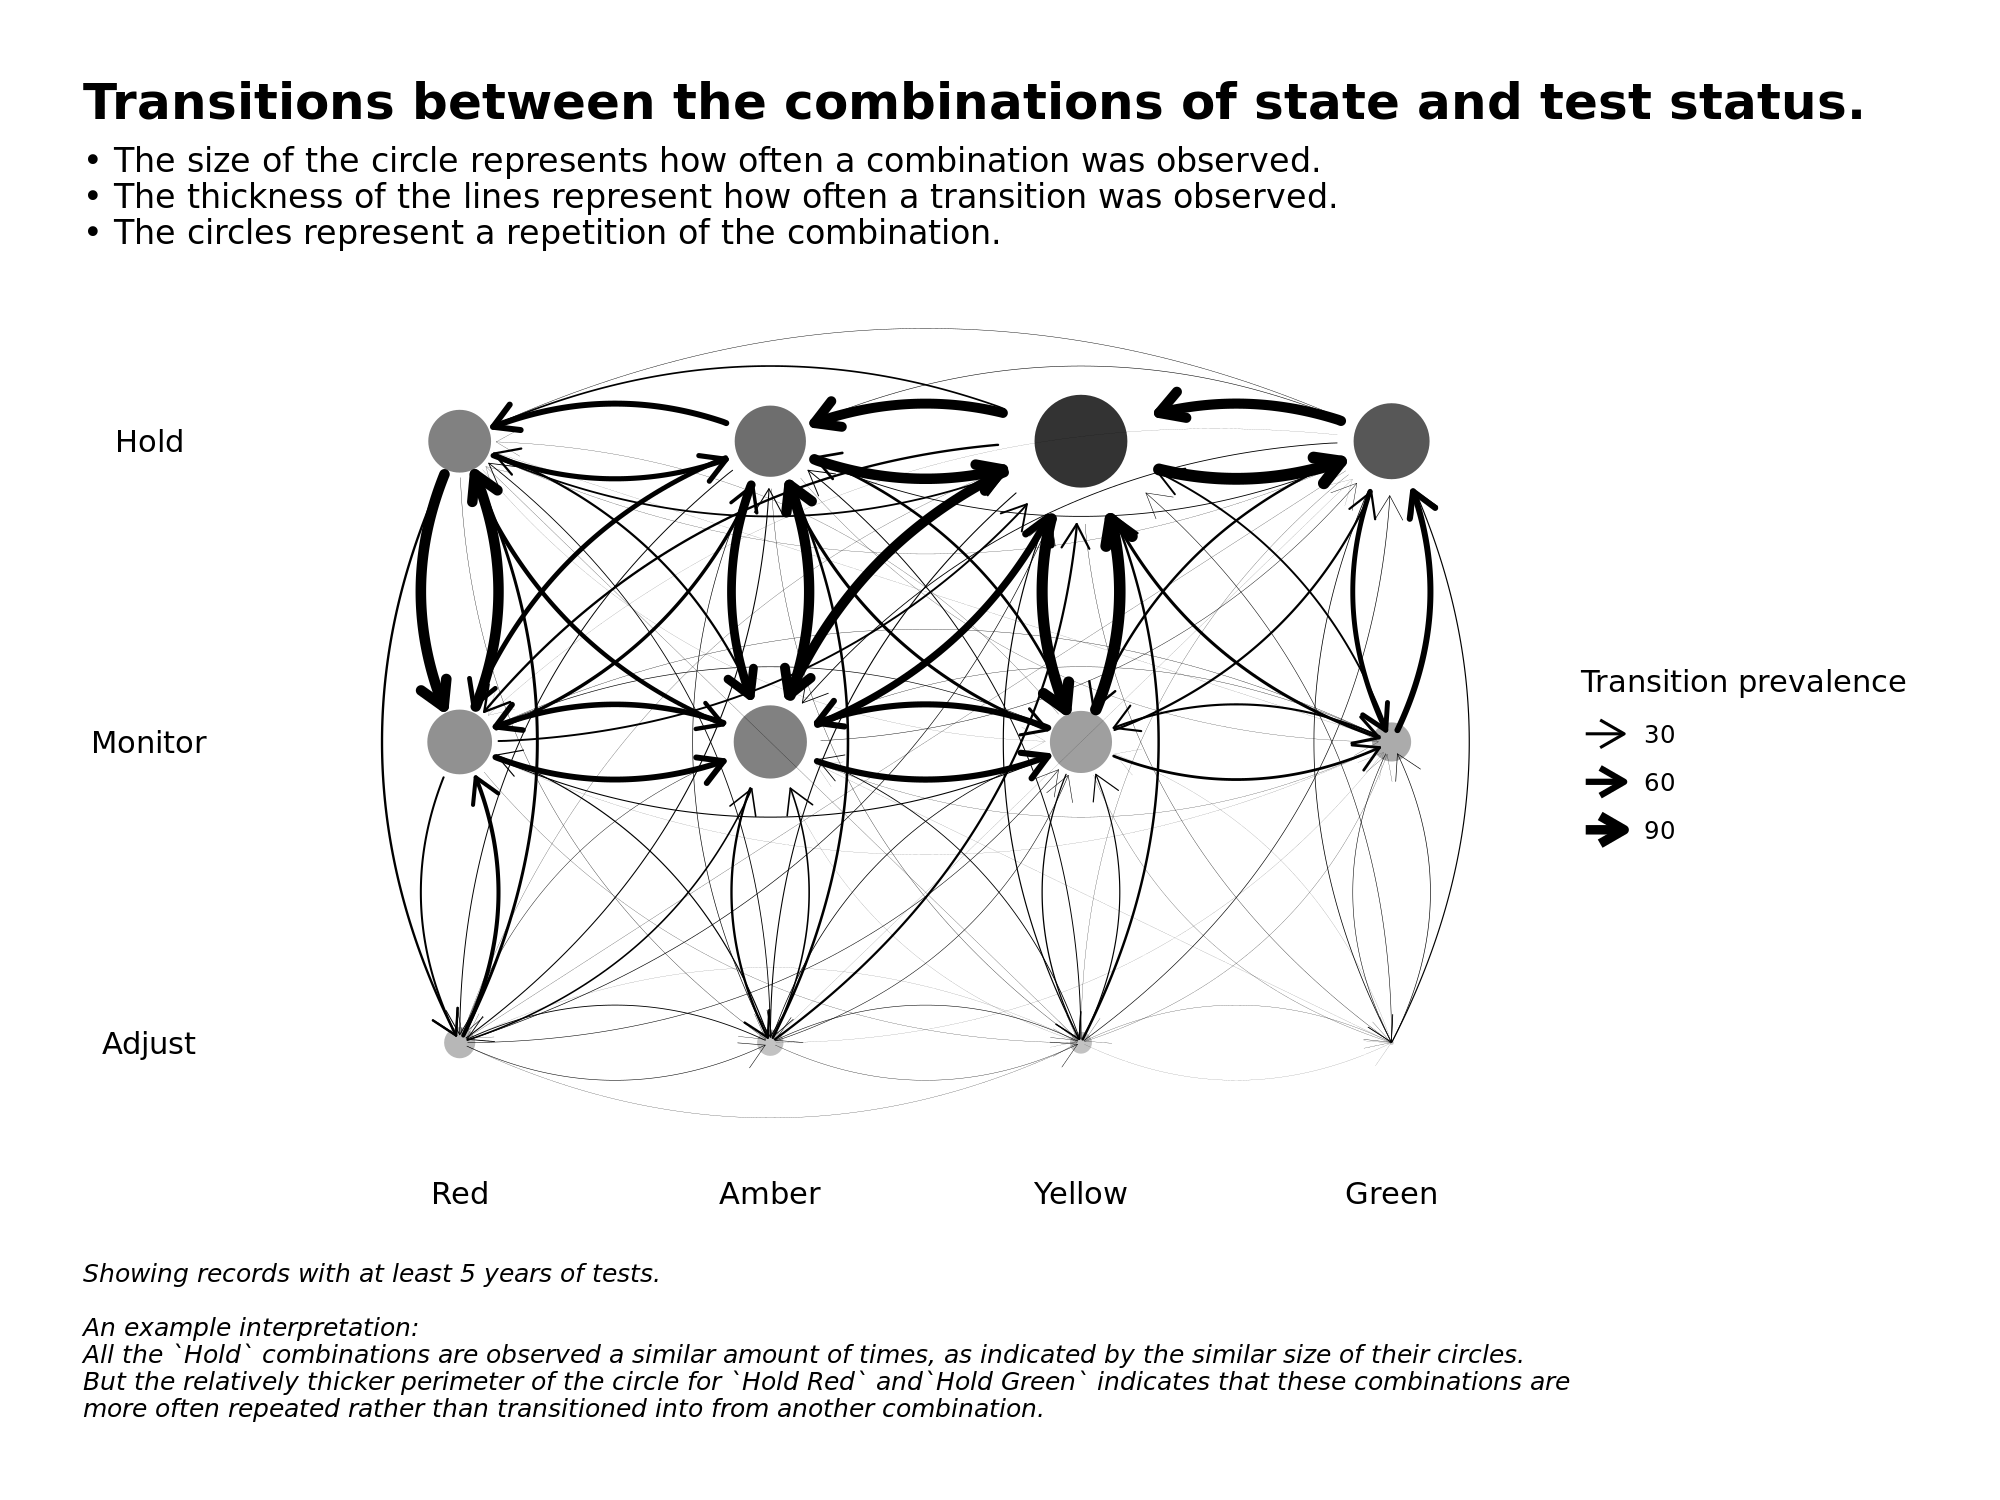

In [19]:
fnc__plot_transition_matrices(
    plot_data = transitions__atLeast_5
    ,save.name = paste0( followup_delay_in_years, "yearsSinceDiagnosis_atLeast_5" )
    ,caption.axes.plot = ""
    ,caption.visits.plot =
        paste0(
            "An example interpretation:\n"
            ,"The `Hold` combinations are more prevalent than combinations involving the other states, and it was very uncommon\n"
            ,"for prescriptions to be adjusted when the test status was `Green`.\n"
        )
    ,caption.transitions.plot = 
        paste0(
            "Showing records with at least 5 years of tests.\n\n"
            ,"An example interpretation:\n"
            ,"All the `Hold` combinations are observed a similar amount of times, as indicated by the similar size of their circles.\n"
            ,"But the relatively thicker perimeter of the circle for `Hold Red` and`Hold Green` indicates that these combinations are\n"
            ,"more often repeated rather than transitioned into from another combination."
        )
)

#### Plots for the dataset of atLeast 10 inter-test intervals.

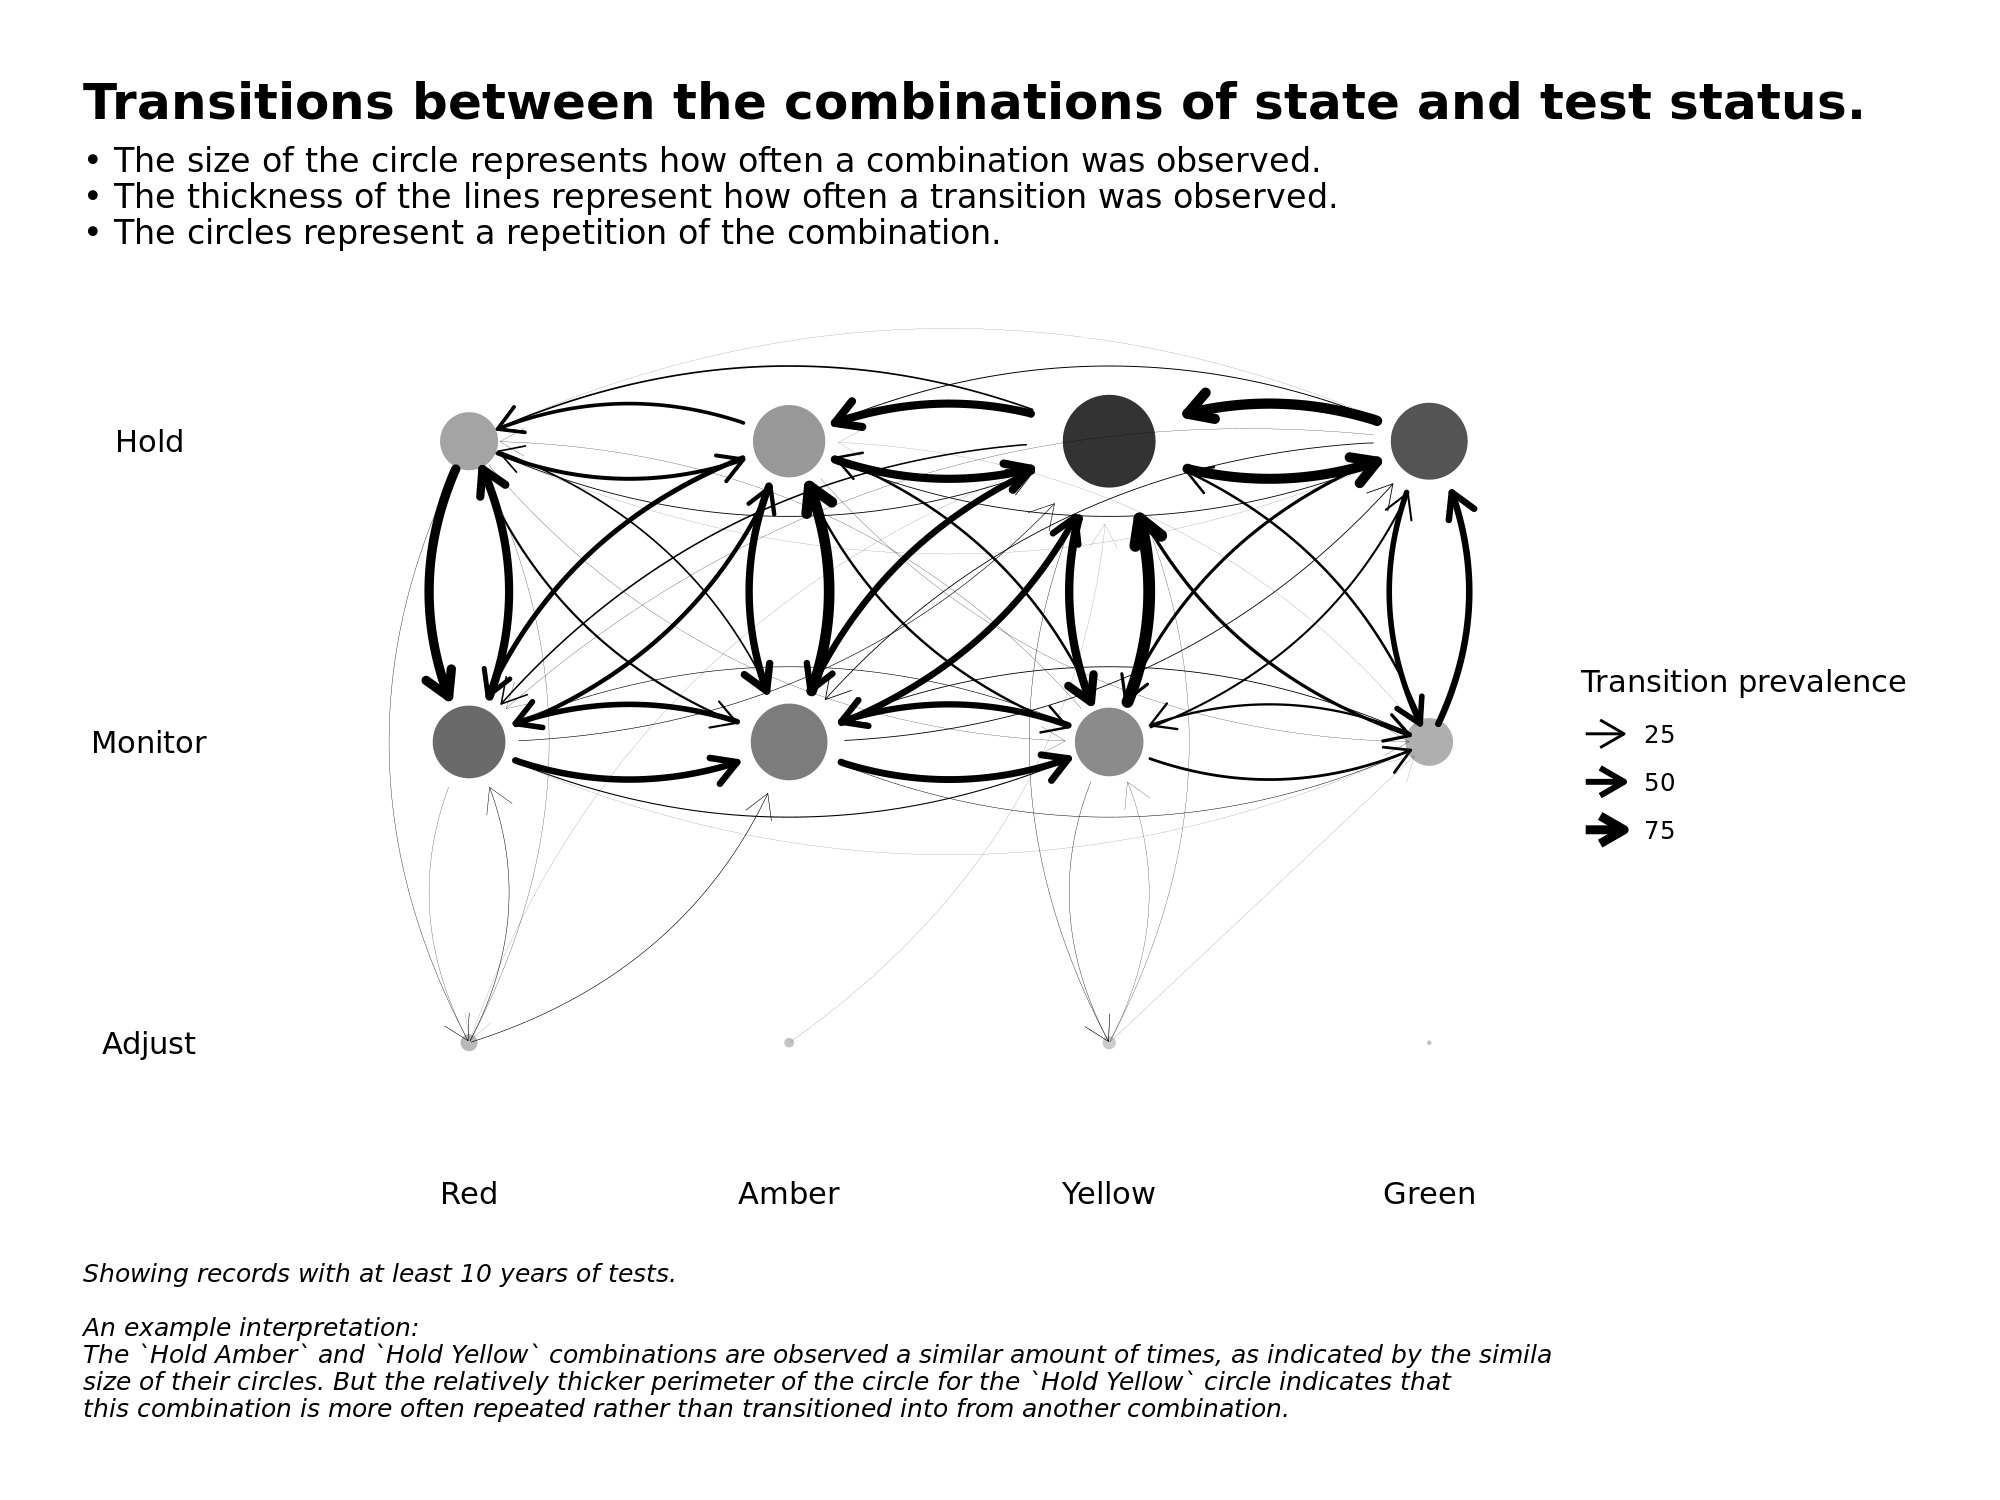

In [20]:
fnc__plot_transition_matrices(
    plot_data = transitions__atLeast_10
    ,save.name = paste0( followup_delay_in_years, "yearsSinceDiagnosis_atLeast_10" )
    ,caption.axes.plot = ""
    ,caption.visits.plot =
        paste0(
            "An example interpretation:\n"
            ,"The `Hold` combinations are more prevalent than combinations involving the other states, and it was very uncommon\n"
            ,"for prescriptions to be adjusted when the test status was `Green`.\n"
        )
    ,caption.transitions.plot = 
        paste0(
            "Showing records with at least 10 years of tests.\n\n"
            ,"An example interpretation:\n"
            ,"The `Hold Amber` and `Hold Yellow` combinations are observed a similar amount of times, as indicated by the simila\n"
            ,"size of their circles. But the relatively thicker perimeter of the circle for the `Hold Yellow` circle indicates that\n"
            ,"this combination is more often repeated rather than transitioned into from another combination."
        )
)

#### Plots for the dataset of atLeast 15 inter-test intervals.

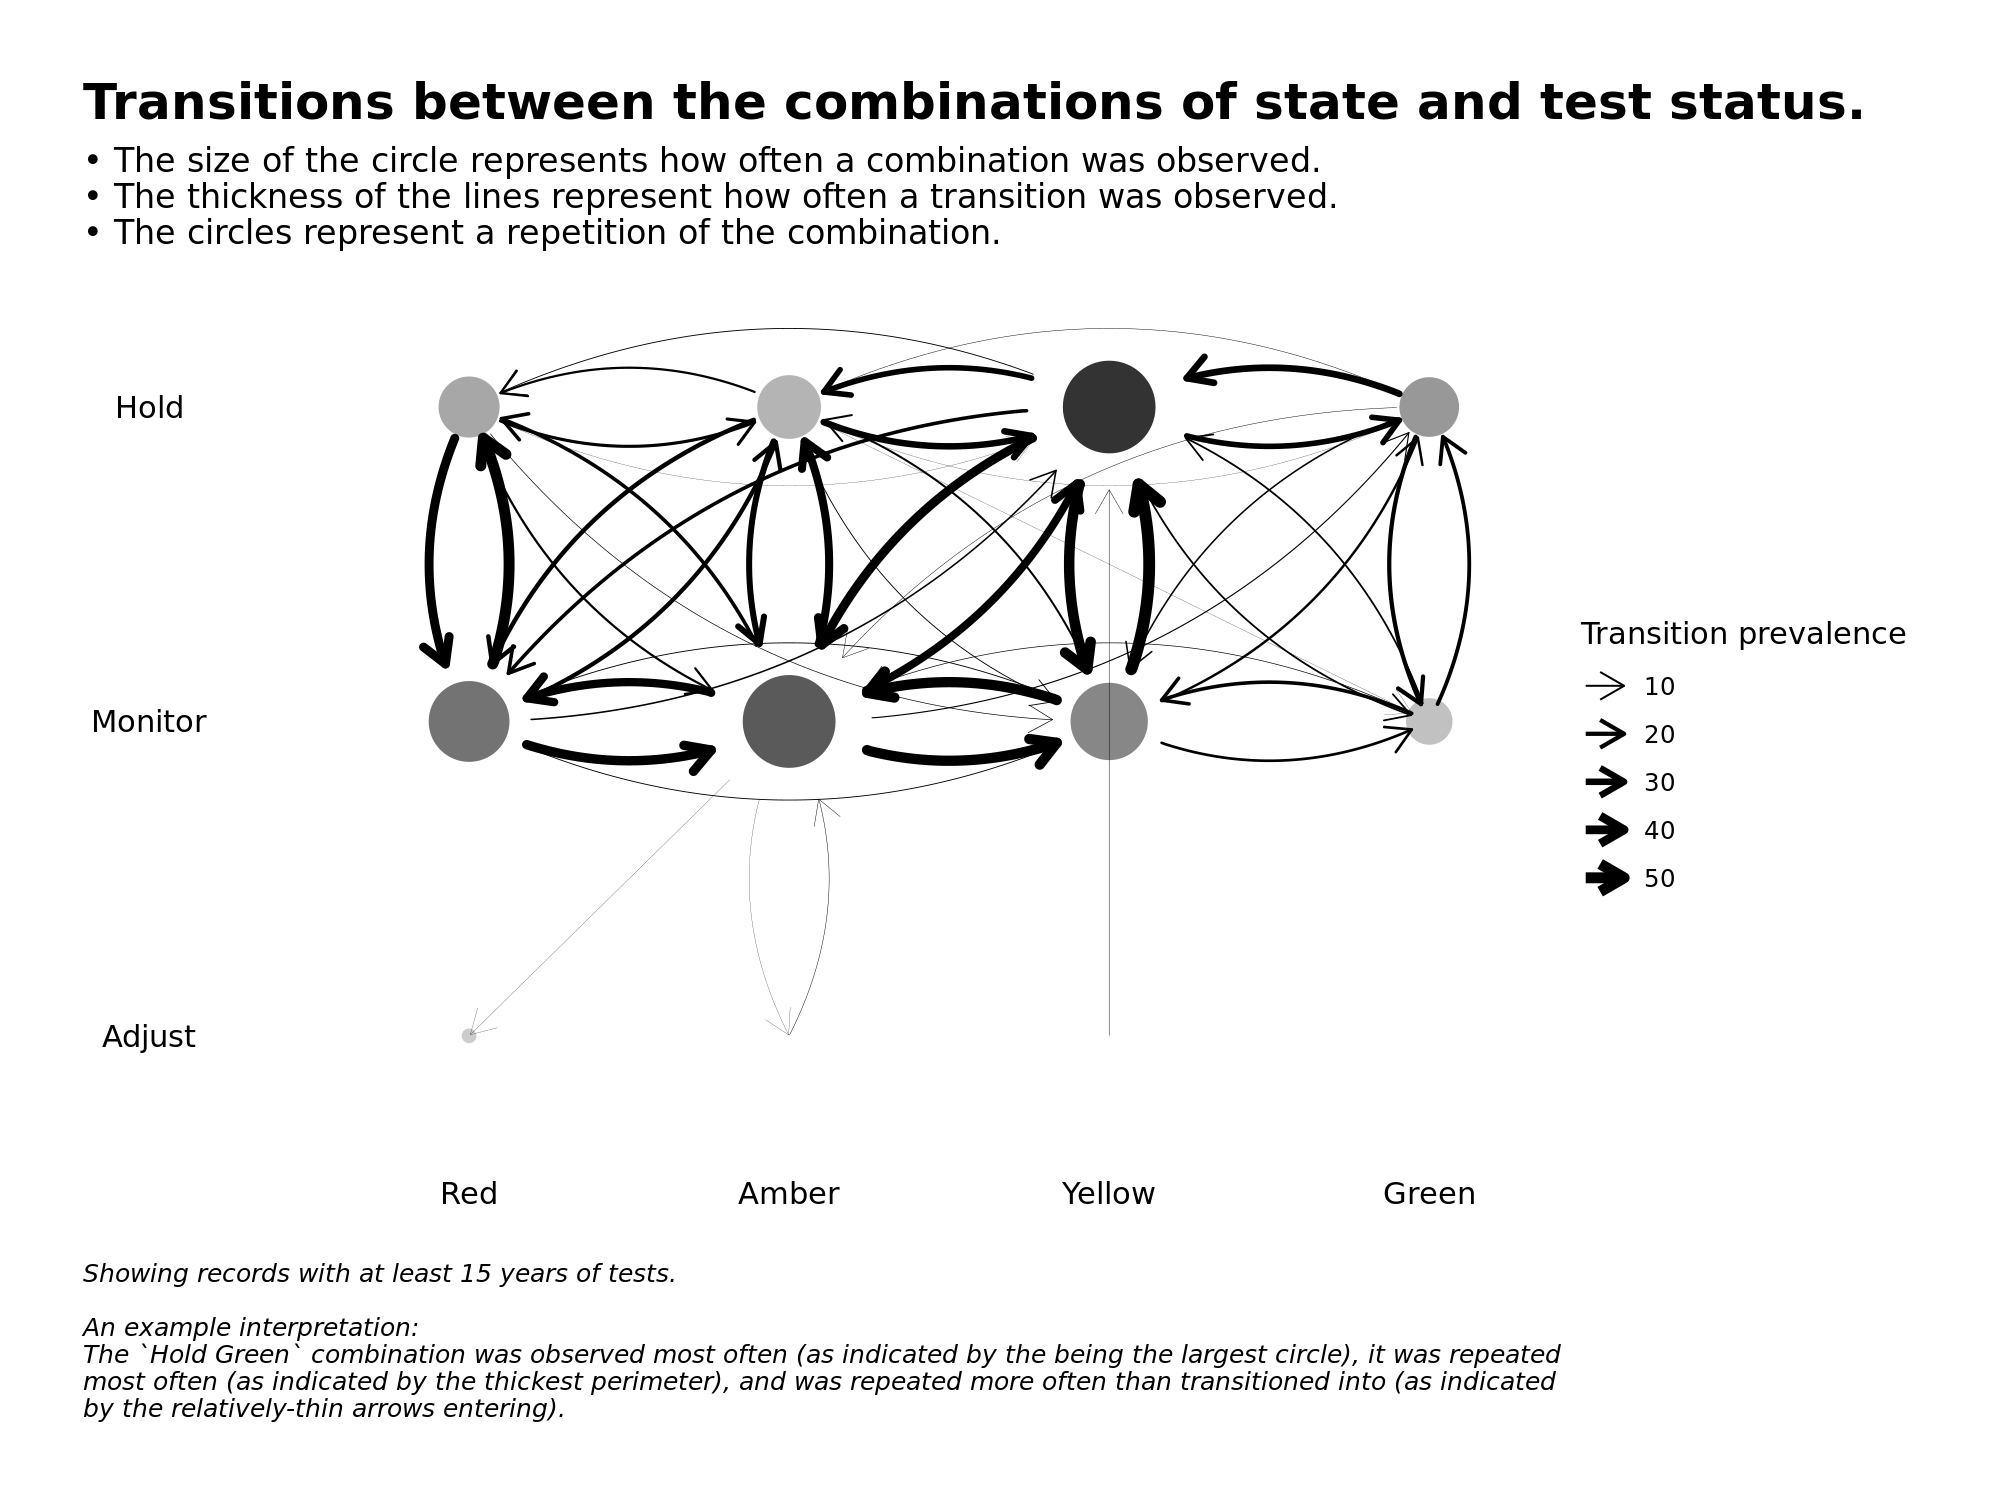

In [21]:
fnc__plot_transition_matrices(
    plot_data = transitions__atLeast_15
    ,save.name = paste0( followup_delay_in_years, "yearsSinceDiagnosis_atLeast_15" )
    ,caption.axes.plot = ""
    ,caption.visits.plot =
        paste0(
            "An example interpretation:\n"
            ,"The `Hold` combinations are more prevalent than combinations involving the other states, and it was very uncommon\n"
            ,"for prescriptions to be adjusted when the test status was `Green`.\n"
        )
    ,caption.transitions.plot = 
        paste0(
            "Showing records with at least 15 years of tests.\n\n"
            ,"An example interpretation:\n"
            ,"The `Hold Green` combination was observed most often (as indicated by the being the largest circle), it was repeated\n"
            ,"most often (as indicated by the thickest perimeter), and was repeated more often than transitioned into (as indicated\n"
            ,"by the relatively-thin arrows entering)."
        )
)

# Concluding comments.

My comments on the plot above are:

1. ...
2. ...

In [22]:
transitions__atLeast_5

subset.idx,x,node,next_x,next_node
<lgl>,<fct>,<fct>,<fct>,<fct>
NA,a3,Hold Yellow,a4,Monitor Yellow
NA,a4,Monitor Yellow,a5,Hold Amber
NA,a5,Hold Amber,a6,Monitor Amber
NA,a3,Hold Yellow,a4,Monitor Amber
NA,a4,Monitor Amber,a5,Hold Yellow
NA,a5,Hold Yellow,a6,Hold Yellow
NA,a3,Hold Amber,a4,Monitor Yellow
NA,a4,Monitor Yellow,a5,Hold Yellow
NA,a5,Hold Yellow,a6,Monitor Amber
